# Tensorflow Similarity Hello World
**Alpha version** here will be dragons


## Notebook goal
Demonstrate the core concept of few-shot learning and how to perform it using TensorFlow Similarity. To do we are going to:
 1. `train()` a similarity model on a sub-set of the 10 fashion MNIST classes that learn how to project images in a cosine space.

 2. `index()` a few examples of each of the class present in the train dataset (e.g 10 per classes).

 3. `lookup()` some the test data to showcase how our models is able to match unseen classes while having only a few examples of each in its index/

 4. `calibrate()` our model to estimate what is the best distance theshold to separate matching elments from elements belonging to different classes.

 5. `evalute()` how well our model/index perform.

 6. `match()` a few examples to test our calibration.

## Performance tips
- The more class you train on the easier it is for the model
- More training epoch  can help improve accuracy
- larger embedding can help improve accuracy
- Augmentation can help improve accuracy
- More examples for calibration gives better results

## Known major limitations
- No `save()` / `load()`
- `batch_lookup()` is broken
- `calibrate()` scores are not correctly computed

There are many other unfinished features and bugs - you have been warmed!


Send feeback to elieb@  - code: [private github (ask for access)](https://github.com/tensorflow/similarity)

In [2]:
 %load_ext autoreload
 %autoreload 2

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  TensorBoard
from time import  time
from tabulate import tabulate
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

In [4]:
import tensorflow_similarity as tfsim
from tensorflow_similarity.utils import tf_cap_memory
from tensorflow_similarity.losses import TripletLoss
from tensorflow_similarity.layers import MetricEmbedding
from tensorflow_similarity.model import SimilarityModel
from tensorflow_similarity.sampler import MultiShotMemorySampler
from tensorflow_similarity.sampler import select_examples
from tensorflow_similarity.visualization import viz_neigbors_imgs
from tensorflow_similarity.visualization import confusion_matrix

In [5]:
# make sure TF don't blew up
tf_cap_memory()
print('TensorFlow:', tf.__version__)
print('TensorFlow Similarity', tfsim.__version__)

TensorFlow: 2.4.0-rc3
TensorFlow Similarity 0.4.1alpha


**Important**: Tensorflow similarity expect `y_train` to be the examples class as integers. Accordingly contrary to a standard classification that do categorical encoding we are leavig `y_train` as is.

In [6]:
NUM_CLASSES = 5  #@param {type: "slider", min: 1, max: 10}
classes = list(range(10))
# note we added a 11 classes for unknown
labels = ["T-shirt",  "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot", "Unknown"]
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = tf.constant(x_train / 255.0, dtype='float32')
x_test = tf.constant(x_test / 255.0, dtype='float32')

x_restricted, y_restricted = select_examples(x_train, y_train, classes[:NUM_CLASSES], 10000)
print(x_restricted.shape, y_restricted.shape)

(30000, 28, 28) (30000,)


To learn efficiently each batch must contains at least 2 sample of each class. Additionally it is often useful to have multiple examples of each class so we can mine informative triplet using different mining strategies (e.g *semi-hard* mining).

To make this easy tf_similarity offers `Samplers()` that allows to control the number of classes and minimal ammount of examples in each class. Here we are going `MultiShotMemorySampler()` which allows to sample a dataset that reside in memory and have muliples examples per class.

In [7]:
BATCH_SIZE = 32 #@param {type:"integer"}
CLASS_PER_BATCH = 8 #@param {type:"integer"}
sampler = MultiShotMemorySampler(x_restricted, y_restricted, class_per_batch=CLASS_PER_BATCH, batch_size=BATCH_SIZE)

# model creation

In [8]:
def get_model():
    tf.keras.backend.clear_session()
    inputs = tf.keras.layers.Input(shape=(28,28))
    x = layers.Reshape((28,28,1))(inputs)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    # dont make the embedding to large - its slow down the lookups
    outputs = MetricEmbedding(32)(x)
    return SimilarityModel(inputs, outputs)
model = get_model()
model.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)    

# Loss definition

Overall Similarity losses (aka metric losses) are similar to other losses except they expect different inputs.

For triplet loss, one of the most popular one, you need to decide what type of triplet mining you want. Usually `hard` mining for positive example and `semi-hard` mining work well and are the default. They are passed explicitly here for reference.

The `distance` parameters specify which distance metric to use to compute the distance between embeddings. `cosine` is usually a great starting point and the default.


In [9]:
distance = 'cosine' #@param ["cosine"]{allow-input: false}
positive_mining_strategy = 'hard' #@param ["easy", "hard"]{allow-input: false}
negative_mining_strategy = 'semi-hard'  #@param ["easy", "semi-hard", "hard"]{allow-input: false}
triplet_loss = TripletLoss(distance=distance,
    positive_mining_strategy=positive_mining_strategy,
    negative_mining_strategy=negative_mining_strategy)

# Compilation

Tensorflow similarity use an extended `compile()` method that allows you to specify distance_metrics (metrics that are computed over the distance between the embedding). 

By default the `compile()` method try to infers what type of distance you are using by looking at the fist loss specified. If you use multiples losses and the distance loss is not the first, then you need to specify the distance function used as `distance=` parameter in the compile function.

In [10]:
STEPS_PER_EXECUTION = 10  # speedup execution by grouping batchs
model = get_model()
model.compile(optimizer='adam', steps_per_execution=STEPS_PER_EXECUTION, loss=triplet_loss)

# Training

Similarity are trained like normal model. Don't expect the validation loss to decrease too much because we only use half of the class on the train data but all class in the validation.

In [11]:
EPOCHS = 10 #@param {type:"integer"}

history = model.fit(sampler, validation_data=(x_test, y_test), batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/10
1000/1000 [==============================] - 18s 18ms/step - loss: 0.7169 - val_loss: 0.8555
Epoch 2/10
1000/1000 [==============================] - 18s 18ms/step - loss: 0.4994 - val_loss: 0.8560
Epoch 3/10
1000/1000 [==============================] - 18s 18ms/step - loss: 0.4568 - val_loss: 0.8154
Epoch 4/10
1000/1000 [==============================] - 18s 18ms/step - loss: 0.4175 - val_loss: 0.8402
Epoch 5/10
1000/1000 [==============================] - 18s 18ms/step - loss: 0.3859 - val_loss: 0.8332
Epoch 6/10
1000/1000 [==============================] - 17s 17ms/step - loss: 0.3796 - val_loss: 0.8405
Epoch 7/10
1000/1000 [==============================] - 17s 17ms/step - loss: 0.3597 - val_loss: 0.8205
Epoch 8/10
1000/1000 [==============================] - 17s 17ms/step - loss: 0.3416 - val_loss: 0.8314
Epoch 9/10
1000/1000 [==============================] - 17s 17ms/step - loss: 0.3427 - val_loss: 0.8471
Epoch 10/10
1000/1000 [==============================] - 18s 18m

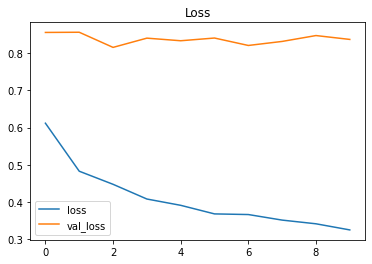

In [12]:
# let's visualizing loss overtime
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.show()

# Indexing

Indexing is where things get different from traditional classification models. Because the model learned to output an embedding that represent the example position in a metric space and not a classification, we need a way to find which known example(s) are the closest to determine the class of the incoming data (aka nearest neighboors classication).

To do so we need to **create an index of known example from the 10 cloth classes**. We do this by taking **100 examples from the train dataset which amount to 10 examples** for each class and use the `index()` funtion of the model to build the index.

Adding more examples per class, helps increase the accuracy/generalization as you improve the set of known variations that the classifier "knows". 

In [13]:
x_index, y_index = select_examples(x_train, y_train, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 10)
# no necessarly needed but ensure we clean the index in case of a re-run
model.index_reset()
model.index(x_index, y_index)

# Querying

To "classify" our testing data, we need for each testing example to look for its *k* [nearest neighbors](https://scikit-learn.org/stable/modules/neighbors.html) in the index.

We query a single random example for each class from the test dataset using  `select_examples()` and then find their nearest neighboors using the `single_lookup()` function.

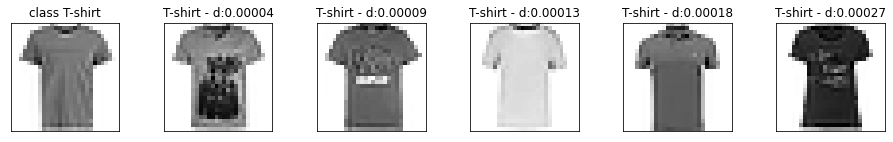

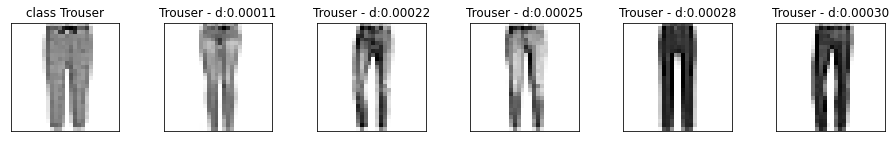

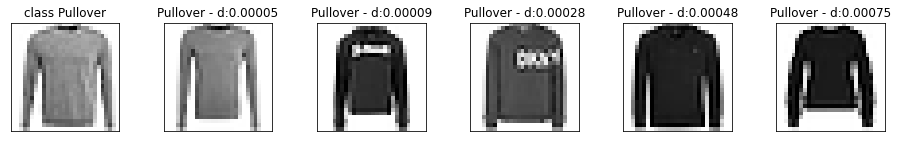

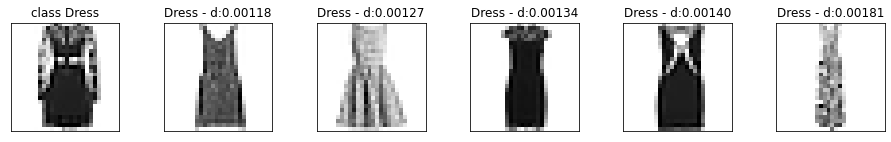

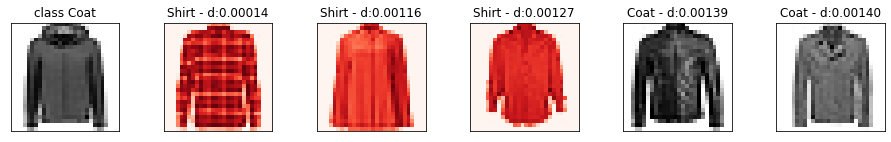

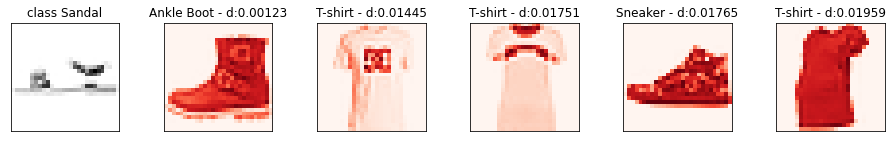

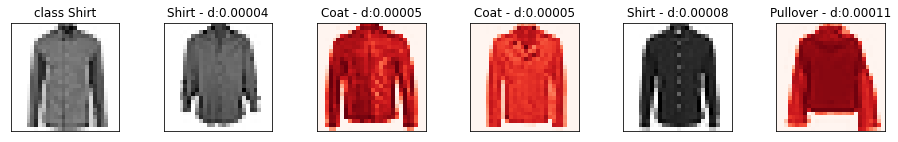

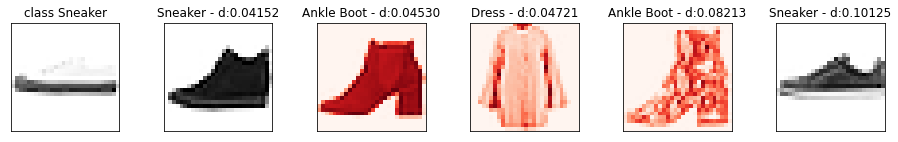

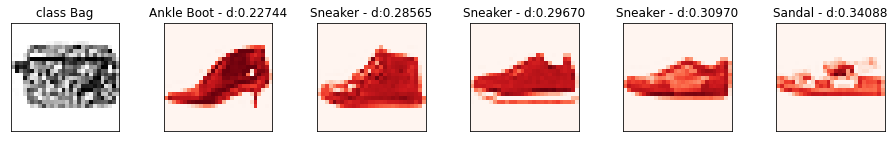

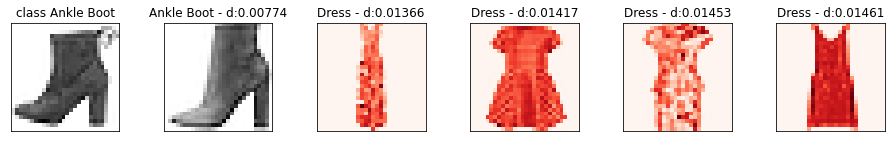

In [14]:
# re-run to test other examples
num_neighboors = 5
x_display, y_display = select_examples(x_test, y_test, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 1)

for idx in np.argsort(y_display):
    # query closest matches
    neighboors = model.single_lookup(x_display[idx], k=num_neighboors)

    # view results close by
    viz_neigbors_imgs(x_display[idx], y_display[idx], neighboors, labels=labels, fig_size=(16, 2), cmap='Greys')



# matching

To be able to tell if an example match a given class, we first need to `calibrate()` the model to know what is the optimal cut point. We compute several cutpoints that correspond to different performance profile:
- **match** is the optimal cutpoint that represent the best balance between precision and recall
- **very likely** is the distance cutpoint that aim to ensure a 0.99 precision.

In [15]:
num_calibration_samples = 1000
calibration = model.calibrate(x_train[:num_calibration_samples], y_train[:num_calibration_samples], verbose=1)

num positive matches 1139/2000




cutpoint       distance
-----------  ----------
optimistic    0
very_likely   0
optimal       0.0118874


Let's look how the performance metrics evolve as the distance between the sample increase. We clearly see the F1 optimial cutpoint where the precision and recall intersect.

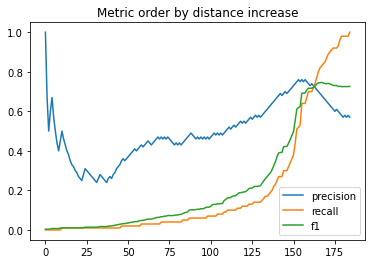

In [16]:
plt.plot(calibration['thresholds']['precision'], label='precision')
plt.plot(calibration['thresholds']['recall'], label='recall')
plt.plot(calibration['thresholds']['f1'], label='f1')
plt.legend()
plt.title("Metric order by distance increase")
plt.show()

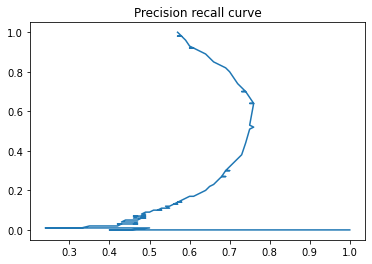

In [17]:
plt.plot(calibration['thresholds']['precision'], calibration['thresholds']['recall'])
plt.title("Precision recall curve")
plt.show()

# Evaluation
We evaluate our model ability to accurately match new examples using our calibrated threshold by testing how many examples from the test sets are correctly matched. The example which have a distance above the cutoff are excluded and labeled as unknown.

The evaluation below reports 

In [18]:
metrics = model.evaluate_index(x_test, y_test)


metric       optimistic    very_likely    optimal
---------  ------------  -------------  ---------
precision           nan            nan   0.643428
recall                0              0   0.7502
f1                  nan            nan   0.692724


# match

Let's now match a 100 examples to see how you can use the `match()` function in practice. `match()` return you what class the example belong to based of the content of the index and allows to use your model to make prediction on an unbounded, added after training, classes!

Note: `match()` return -1 by default when the distance between the submited example and any point of the index is above the distance cutpoint.

**note** This API is WIP -- its unclear what should be returned 

In [19]:
num_matches = 10

matches = model.match(x_test[:num_matches], cutpoint='optimal')
rows = []
for idx, match in enumerate(matches):
    rows.append([match, y_test[idx], match == y_test[idx]])
print(tabulate(rows, headers=['Predicted', 'True', 'correct']))

  Predicted    True    correct
-----------  ------  ---------
          9       9          1
          2       2          1
          1       1          1
          1       1          1
         -1       6          0
          1       1          1
          4       4          1
          6       6          1
          0       5          0
          9       7          0


## confusion matrix
Let's select a few hundreds samples for each class in the test set to plot the confusion matrix for a few

**note** `tf.math.confusion_matrix` doesn't support negative class so we are going to use **10 as our unknown class**

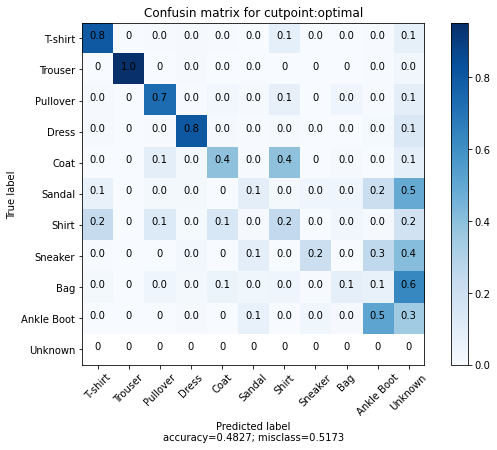

In [20]:
num_example_per_class = 1000
cutpoint = 'optimal'  #@param ["optimal", "very_likely", "likely", "optimistic"]

x_confusion, y_confusion = select_examples(x_test, y_test, range(10), num_example_per_class)

matches = model.match(x_confusion, cutpoint=cutpoint, no_match_class=10)
confusion_matrix(matches, y_confusion, labels=labels, title='Confusin matrix for cutpoint:%s' % cutpoint)

# Additional features

To be moved to the other colabs

## Indexer stats

You can display the indexer performance summary using the `index_summary()` function.

In [21]:
model.index_summary()

[Index statistics]
----------------  -----
query_time            0
query                 0
num_lookups       21020
num_items           100
stat_buffer_size    100
----------------  -----

[Query performance]
------  -----------
min     0
max     0.000499725
avg     9.99451e-06
median  0
stddev  6.99615e-05
------  -----------


## Threshold viz

In [22]:
rows = []
thresholds = calibration['thresholds']
for idx in range(len(thresholds['distance'])):
    rows.append([thresholds['distance'][idx], thresholds['f1'][idx], thresholds['precision'][idx], thresholds['recall'][idx]])

print(tabulate(rows, headers=['distance', 'f1', 'precision', 'recall']))

   distance          f1    precision    recall
-----------  ----------  -----------  --------
0            0.0035057          1         0
0            0.00350263         0.67      0
0            0.00349956         0.5       0
0            0.00524476         0.6       0
0            0.0069869          0.67      0
0            0.0069808          0.57      0
0            0.00697472         0.5       0
0            0.00696864         0.44      0
0            0.00696258         0.4       0
0            0.00869565         0.45      0
0            0.0104257          0.5       0.01
0            0.0104167          0.46      0.01
0            0.0104076          0.43      0.01
0            0.0103986          0.4       0.01
0            0.0103896          0.38      0.01
0            0.0103806          0.35      0.01
0            0.0103717          0.33      0.01
0            0.0103627          0.32      0.01
0            0.0103538          0.3       0.01
0            0.0103448          0.29      0